# Estimation of MET cross section with Madgraph 3.6.2

## Import MG5 and dependencies

In [72]:
import os
import sys

sys.path.append('../src') # Only if madpy is not installed

MADGRAPH_PATH = f"../mg5amcnlo"
sys.path.append(MADGRAPH_PATH)

from madgraph.interface.master_interface import MasterCmd

mg = MasterCmd()

In [73]:
# Import SM model to check if it's working
mg.exec_cmd("import model sm")


## Install models and plugins

### [DMSimp](https://feynrules.irmp.ucl.ac.be/wiki/DMsimp)

Simplified DM extension with a scalar mediator and three DM candidates

In [74]:
### DMSimp
# - https://feynrules.irmp.ucl.ac.be/wiki/DMsimp 

mg.exec_cmd("import model DMsimp_s_spin0")
#from madgraph.core.base_objects import Model
# PDG number 9000001 to particle ghA
# PDG number 9000002 to particle ghZ
# PDG number 9000003 to particle ghWp
# PDG number 9000004 to particle ghWm
# g ghg ghg~ u c d s b u~ c~ d~ s~ b~ a gha gha~ ve vm vt e- mu- ve~ vm~ vt~ e+ mu+ t t~ z w+ ghz ghwp ghwm h xr xc y0 w- ghz~ ghwp~ ghwm~ xc~ ta- xd ta+ xd~

Xr = {'name': 'xr',
      'pdg_code': 5000001} # real scalar DM
Xc = {'name': 'xc',
      'pdg_code': 51} # complex scalar DM

Xd = {'name': 'xd',
      'pdg_code': 52} # dirac DM DM

Y0 = {'name': 'y0',
      'pdg_code': 54} # real scalar DM

# TODO: Seems like Xv (vector) needs to be implemented. Search for complementary model


Pass the definition of 'j' and 'p' to 5 flavour scheme.


In [75]:
mg.exec_cmd("import model DMsimp_s_spin0")

In [76]:
sys.path.append('../')

In [77]:
## Write and execute an script for mg5


script_file_name = "new_process.mg5" ## the *.mg5 file extension is optional
workdir_path = "../workdir"
process_dir = "new_process"
workdir_process = f"{workdir_path}/{process_dir}"

# import model DMsimp_s_spin0
# generate p p > xd xd~ a / a z [QCD]
## Generate files at output
# set param_card mass 5000001  1.720000e+02
# launch {workdir_process} -i
#     print_results --path=./cross_section_top.txt --format=short
## scan or scan1 (for zip combinations)

mg5_script = f"""\
generate p p > t t~ j
output {workdir_process} -f
launch {workdir_process}
    set mass mt scan:[170,175,180, 190, 200]
    set decay wt Auto # changing the top width
    set ptj 40 # changing the ptj cut
    madspin=ON
    set nevents 1k
"""

with open(script_file_name, "w") as script_file:
    script_file.write(mg5_script)

In [78]:
mg5_executable = f"{MADGRAPH_PATH}/bin/mg5_aMC"
# executable rather than the "./bin/madevent" one

In [79]:
import subprocess
from subprocess import Popen, PIPE, CalledProcessError

def madpy_generate_script(process: str = "p p > t t~ j",
                          model: str = "sm",
                          masses: dict | None = {"mt": "scan:[190, 200]"},
                          decays: dict | None = {"wt": "Auto"},
                          pt_cut: dict | None = {"ptj": "40"},
                          madspin: bool = True,
                          number_events: int = 1000,
                          script_file_name: str = "new_process.mg5",
                          workdir_path: str = "../workdir",
                          process_dir: str = "new_process",
                          draw_diagrams: bool = True):
    
    workdir_process = f"{workdir_path}/{process_dir}"
    
    mg5_script = f"""\
import model {model}
generate {process}
output {workdir_process} -f
display diagrams
launch {workdir_process}"""
    
    if masses:
        for particle, mass in masses.items():
            mg5_script += "\n\t" + f"""set mass {particle} {mass}"""
    
    if decays:
        for decay, value in decays.items():
            mg5_script += "\n\t" + f"""set width {decay} {value}"""
    
    if pt_cut:
        for pt, cut in pt_cut.items():
            mg5_script +=  "\n\t" + f"""set {pt} {cut}"""
    
    if madspin:
        mg5_script += "\n\t" + f"""madspin=ON"""
        
    # Set number of events
    mg5_script += "\n\t" + f"""set nevents {number_events}"""
    
    
    mg5_script += "\n\t" + f"""set run_card ebeam1 = 7500"""
    mg5_script += "\n\t" + f"""set run_card ebeam2 = 7500"""
    
    
    
    with open(script_file_name, "w") as script_file:
        script_file.write(mg5_script)
        
    return mg5_script, script_file_name
    
def madpy_run(mg5_script_path: str, mg5_bin: str = "mg5_aMC", madgraph_path = MADGRAPH_PATH):
    
    mg5_executable = f"{madgraph_path}/bin/{mg5_bin}"
    subprocess.run([mg5_executable, mg5_script_path])



#*********************************************************************
# Collider type and energy                                           *
# lpp: 0=No PDF, 1=proton, -1=antiproton,                            *
#                2=elastic photon of proton/ion beam                 *
#             +/-3=PDF of electron/positron beam                     *
#             +/-4=PDF of muon/antimuon beam                         *
#*********************************************************************
    #  1        = lpp1    ! beam 1 type 
    #  1        = lpp2    ! beam 2 type
#          6500.0     = ebeam1  ! beam 1 total energy in GeV
#      6500.0     = ebeam2  ! beam 2 total energy in GeV
# # To see polarised beam options: type "update beam_pol"

In [80]:
# Generate script
full_script_str, mg5_script_path = madpy_generate_script(process = "p p > Y0 > xd xd~ a",
                                                         model = "DMsimp_s_spin0",
                                                         script_file_name = "dm_process.mg5",
                                                         process_dir= "dmsimp_v1",
                                                        masses = {"mxd": "scan:[500, 1000, 1400, 1500]",
                                                                  "my0": "3000"},
                                                        decays = {"9000001": "Auto",
                                                                  "9000002": "Auto",
                                                                  "9000003": "Auto",
                                                                  "9000004": "Auto"},
                                                        pt_cut = None,
                                                        madspin = False,
                                                        number_events = 1000,
                                                         )



In [81]:
madpy_run(mg5_script_path)


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.6.3                 2025-06-12         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


INFO: get decay diagram for ghz 
Vertexlist of this model has not been searched.Automatically run the model.find_vertexlist()
Found 7 stable particles
INFO: get decay diagram for ghwp 
INFO: get decay diagram for ghwm 
No three body-decay (or higher) is found for {9000002, 9000003, 9000004}
No need for N body-decay (N>2). Results are in /home/mjrxy/MadPy/workdir/dmsimp_v1/Cards/param_card.dat
INFO: Update the dependent parameter of the param_card.dat 
Generating 1000 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/mjrxy/MadPy/workdir/dmsimp_v1/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_qq_xdxdxa  
GC_73 GC_81 GC_13
This will slow down the computation. Please consider using restricted model:
https://answers.launchpad.net/mg5amcn

100%|█████████████████████████████████████| 769/769 [00:00<00:00, 91345.79it/s]


INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 18h13 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.28s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.64s  ] 
INFO: End survey 
refine 1000
Creating Jobs
INFO: Refine results to 1000 
INFO: Generating 1000.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 123198478.90944704 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 9.740380000000001e-06 +- 1.2176049864286858e-07
    P1_qq_xdxdxa 
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 18h13 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1s  ] 
INFO: Combining runs 
sum of cpu time of last step: 2 seconds
INFO: finish refine 
refine 1000 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 0.6070034503936768 s 
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   9.711e-06 +- 3.518e-08 pb
  

In [ ]:
   # Same cross section, different errors bars :] 
    #     Cross-section :   0.0003166 +- 5.396e-07 pb
    #  Nb of events :  10000
    # Cross-section :   0.0003185 +- 1.277e-06 pb
    #  Nb of events :  1000
    # #  Cross-section :   0.0003163 +- 2.277e-06 pb
    # #  Nb of events :  500
    
    
# TODO: Compare a useful cross section with those I have!!!
# TODO: Learn how to parallize those jobs

In [25]:
import pandas as pd
results_dataframe = pd.DataFrame()

In [34]:
workdir_process

'../workdir/dmsimp_v1'

In [39]:
pd.read_csv(workdir_process + '/Events/scan_run_0[1-4].txt', delimiter=' ').dropna(axis=1)

,#run_name,Unnamed: 15,Unnamed: 24,Unnamed: 33,error,Unnamed: 51,Unnamed: 60
0,run_01,500.0,9.711480e-06,3.517785e-08,0.0,0.0,0.0
1,run_02,1000.0,4.794451e-06,1.627747e-08,0.0,0.0,0.0
2,run_03,1400.0,5.338335e-07,1.810071e-09,0.0,0.0,0.0
3,run_04,1500.0,1.042978e-08,7.169126e-11,0.0,0.0,0.0


In [56]:
workdir_process = f"{workdir_path}/dmsimp_v1"
with open(workdir_process + '/Events/scan_run_0[1-4].txt', "r") as file:
    scan_run_txt = script_file.read(file)

TypeError: argument should be integer or None, not '_io.TextIOWrapper'

In [27]:
results_dataframe['test'] = [1,2,3,4,5]

In [28]:
results_dataframe

,test
0,1
1,2
2,3
3,4
4,5


### Show diagrams here [? how ?]

In [13]:
mg.draw('myHiggsProc')

Not able to open file myHiggsProc/diagrams_0_uux_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt
Not able to open file myHiggsProc/diagrams_0_ddx_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt


In [8]:
mg.exec_cmd("display diagrams")

Not able to open file /tmp/diagrams_0_uux_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt
Not able to open file /tmp/diagrams_0_ddx_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt


In [18]:
import glob
from IPython.display import Image, display

diagram_files = sorted(glob.glob("myHiggsProc/HTML/diagram*.png"))

for f in diagram_files:
    display(Image(filename=f))

## Read info from generated files

### Unpack lhe files

In [65]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lhe_file = '/home/mjrxy/MadPy/workdir/new_process/Events/run_01/unweighted_events.lhe.gz'

def unpack_events(events_path):
    try:
        #output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", events_path])
        print("Arquivo LHE descompactado com sucesso.")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

unpack_events(lhe_file)

Arquivo LHE descompactado com sucesso.


In [ ]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MG_VERSION = "v3_6_2"

import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lhe_file = '/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe.gz'
def unpack_events(events_path):
    # Caminho para o arquivo de saída com eventos gerados
    output_file = events_path # os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe")
    try:
        #output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", "-k", output_file])
        print("Arquivo LHE descompactado com sucesso.")
        
        return events_path.strip(".gz")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

lhe_file = '/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe.gz'
output_lhe_file = unpack_events(lhe_file)


Arquivo LHE descompactado com sucesso.


gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe already exists;	not overwritten


In [71]:
output_lhe_file

'/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe'

In [101]:
# Extract cross section from LHE file
def get_cross_section(lhe_file):
    cross_section = None
    with open(lhe_file, 'r') as file:
        in_init_block = False
        for line in file:
            if "<init>" in line:
                in_init_block = True
            elif "</init>" in line:
                in_init_block = False
                break
            elif in_init_block:
                data = line.strip().split()
                if len(data) <= 6:
                    cross_section = float(data[0]) 
                    error = float(data[1])
                    break
    return cross_section, error

# Extract the events and convert it to pandas format
def parse_lhe_file(file_path, cross_section, error, run_number=None):
    events = []
    event_id = 0

    with open(file_path, 'r') as file:
        in_event = False
        for line in file:
            if "<event>" in line:
                in_event = True
                event = []
                event_id += 1  # Incrementa o ID do evento a cada novo evento
            elif "</event>" in line:
                in_event = False
                events.append(event)
            elif in_event:
                data = line.strip().split()
                if len(data) >= 6:
                    try:
                        particle_data = list(map(float, data))
                        particle_data.append(event_id)  # Adiciona o ID do evento à partícula
                        event.append(particle_data)
                    except ValueError:
                        #print("line ", line)
                        #print("event id ", event_id)
                        #print('particle data ', particle_data)
                        #print('error in line ', data)
                        pass


                        # TODO: How to extract this info 
                        # <mgrwt>
                        # <rscale>  0 0.43702855E+04</rscale>
                        # <asrwt>0</asrwt>
                        # <pdfrwt beam="1">  1        2 0.25919763E+00 0.43702855E+04</pdfrwt>
                        # <pdfrwt beam="2">  1       -2 0.32749606E+00 0.43702855E+04</pdfrwt>
                        # <totfact> 0.16864895E-01</totfact>
                        # </mgrwt>

            
    # Converte a lista de eventos para um DataFrame
    columns = ["pid", "status", "m_mother1", "mother2", "color1", "color2", "px", "py", "pz", "E", "M", "lifetime", "spin", "event_id"]
    df = pd.DataFrame([item for sublist in events for item in sublist], columns=columns)
    # Adiciona uma coluna de cross-section (mesmo valor para todos os eventos)
    df["cross_section"] = cross_section #pb
    df["cross_section_error"] = error #± pb
    df.dropna(subset=["lifetime", "spin"], inplace=True)
    
    if run_number:
        df['run_number'] = run_number
        

    return df, events

# Extraia a cross-section do arquivo LHE
cross_section_value, cross_section_error = get_cross_section(output_lhe_file)
print(f'Cross section of the run: {cross_section_value} pb +/- {cross_section_error} pb' )


Cross section of the run: 9.71148e-06 pb +/- 3.517785e-08 pb


In [102]:
df_events_merged = pd.DataFrame()
lhe_file = '/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe.gz'
output_lhe_file = unpack_events(lhe_file)
for run in [1, 2, 3, 4]:
    lhe_file = f'/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_0{run}/unweighted_events.lhe.gz'
    output_lhe_file = unpack_events(lhe_file)
    
    df_events, _ = parse_lhe_file(output_lhe_file, cross_section_value, cross_section_error, run_number=run)
    df_events_merged = pd.concat([df_events_merged, df_events])


gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe already exists;	not overwritten
gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe already exists;	not overwritten
gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_02/unweighted_events.lhe.gz: No such file or directory
gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_03/unweighted_events.lhe already exists;	not overwritten


Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.


gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_04/unweighted_events.lhe already exists;	not overwritten


In [103]:
df_events_merged

,pid,status,m_mother1,mother2,color1,color2,px,py,pz,E,M,lifetime,spin,event_id,cross_section,cross_section_error,run_number
1,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,0.000000,1943.982226,1943.982226,0.0000,0.0,1.0,1.0,0.00001,3.517785e-08,1
2,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,-0.000000,-2456.220443,2456.220443,0.0000,0.0,-1.0,1.0,0.00001,3.517785e-08,1
3,54.0,2.0,1.0,2.0,0.0,0.0,612.476625,-894.719000,-34.397685,3215.305509,3026.7733,0.0,0.0,1.0,0.00001,3.517785e-08,1
4,52.0,1.0,3.0,3.0,0.0,0.0,1054.075517,638.417402,556.966260,1441.826408,500.0000,0.0,1.0,1.0,0.00001,3.517785e-08,1
5,-52.0,1.0,3.0,3.0,0.0,0.0,-441.598892,-1533.136402,-591.363945,1773.479101,500.0000,0.0,1.0,1.0,0.00001,3.517785e-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,2201.177140,2201.177140,0.0000,0.0,-1.0,1000.0,0.00001,3.517785e-08,4
6512,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-3408.418752,3408.418752,0.0000,0.0,1.0,1000.0,0.00001,3.517785e-08,4
6513,52.0,1.0,1.0,2.0,0.0,0.0,146.051217,-1244.666732,-1615.490473,2535.810659,1500.0000,0.0,1.0,1000.0,0.00001,3.517785e-08,4
6514,-52.0,1.0,1.0,2.0,0.0,0.0,-901.409811,1194.358992,-163.605877,2125.041160,1500.0000,0.0,1.0,1000.0,0.00001,3.517785e-08,4


### Subtitles for the PIDs

In [ ]:
import pandas as pd


## TODO: Refactor this table with DM particles


# Criação da tabela de referência de partículas
particle_data = {
    "PID": [11, -11, 13, -13, 22, 12, -12, 14, -14, 16, -16, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 21, 23, 24, -24],
    "Name": [
        "Electron", "Positron", "Muon", "Anti-Muon", "Photon",
        "Electron Neutrino", "Electron Anti-Neutrino", "Muon Neutrino", "Muon Anti-Neutrino",
        "Tau Neutrino", "Tau Anti-Neutrino", "Down Quark", "Anti-Down Quark",
        "Up Quark", "Anti-Up Quark", "Strange Quark", "Anti-Strange Quark",
        "Charm Quark", "Anti-Charm Quark", "Bottom Quark", "Anti-Bottom Quark",
        "Gluon", "Z Boson", "W+ Boson", "W- Boson"
    ],
    "Symbol": [
        "e-", "e+", "mu-", "mu+", "a",
        "ve", "ve~", "vm", "vm~",
        "vt", "vt~", "d", "d~",
        "u", "u~", "s", "s~",
        "c", "c~", "b", "b~",
        "g", "z", "w+", "w-"
    ]
}

# Criação do DataFrame com as informações de partículas
particle_df = pd.DataFrame(particle_data)
particle_df.to_csv('particle_names.csv', index=False)
print(particle_df)

In [104]:
total_cross_section = df_events.cross_section.iloc[0] * 1000 # converts to fb
total_cross_section_error = df_events.cross_section_error.iloc[0]
print(total_cross_section, total_cross_section_error)

0.00971148 3.517785e-08


In [ ]:
# TODO: Merge this repository with the scalar DM analysis
# TODO: Put this repository inside SPRACE [?]
# TODO: Get equivalent cross section points for analytical results with mono photon.
# TODO: Get results for those same parameters, for relic density as well (MadDM and Analytical)

## Plotting the mg5 / lhe results

In [ ]:

## Filter neutrino events


# df_events['neutrino'] = 1
# df_events['neutrino'] = -1
# df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True
# df_events.loc[df_events['PID'].isin([-12, -14, -16]), 'anti_neutrino'] = True
# #df_events.loc[df_events['neutrino'], 'PID'] = 12
# #df_events['PID_abs'] = abs(df_events['PID'])
# df_gp = df_events.groupby(['Event_ID', 'neutrino' ,'PID'], as_index=False)['E'].sum()


In [ ]:
import mplhep as hep
# ZZ, a pair of heavier bosons.

def get_hist_bins(df_to_plot, bin_gev):
    
    gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
    M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
    # the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions
    hist, bins = M_hist  # hist=frequency ; bins=Mass values
    return hist, bins
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()
hist1, bins1 = get_hist_bins(df_to_plot, 10)
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()

hist1, bins1 = get_hist_bins(df_to_plot, 10)
fig, ax = plt.subplots(figsize=(10, 5))
bin_gev = 5

hep.histplot(
    [hist1, hist1],
    bins=bins1,
    histtype="fill",
    stack=True,
    color=["b", "r"],
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:

# ZZ, a pair of heavier bosons.
## converts to cross section
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() 
bin_gev = 0.1
#gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=10000) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions


hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="b",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()


In [22]:
hist_df = pd.DataFrame(M_hist).T.rename(columns={0: 'nevents', 1: 'energy_nu'})

In [23]:
hist_df['xsec'] = hist_df['nevents'] * total_cross_section /1000000

In [24]:
hist_df['integrated_xsec'] = 0
xsec_met = {}
for energy in range(1000, 6000, 100):
    xsec_met[energy] = hist_df.loc[hist_df['energy_nu'].between(energy, energy+100), 'xsec'].sum()


In [25]:
energy_xsec_df = pd.DataFrame.from_dict(xsec_met, orient='index', columns=['xsec_met']).reset_index().rename(columns={'index': 'energy_nu'}) 

In [26]:
energy_xsec_df.to_csv('energy_met_xsec.csv', index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
ax.plot(energy_xsec_df['energy_nu'], energy_xsec_df['xsec_met'])
ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()

In [ ]:
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hep.style.use("CMS")
# ZZ, a pair of heavier bosons.
df_to_plot = df_gp.loc[df_gp['PID'].isin([22]), 'E'].to_numpy()
df_to_plot
bin_gev = 100
gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions

hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="y",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\gamma$ energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:
df_gp.loc[df_gp['PID'].isin([12]), 'E'].hist(bins=50)#.set_xlim(1000, 1500)


(1000.0, 1500.0)

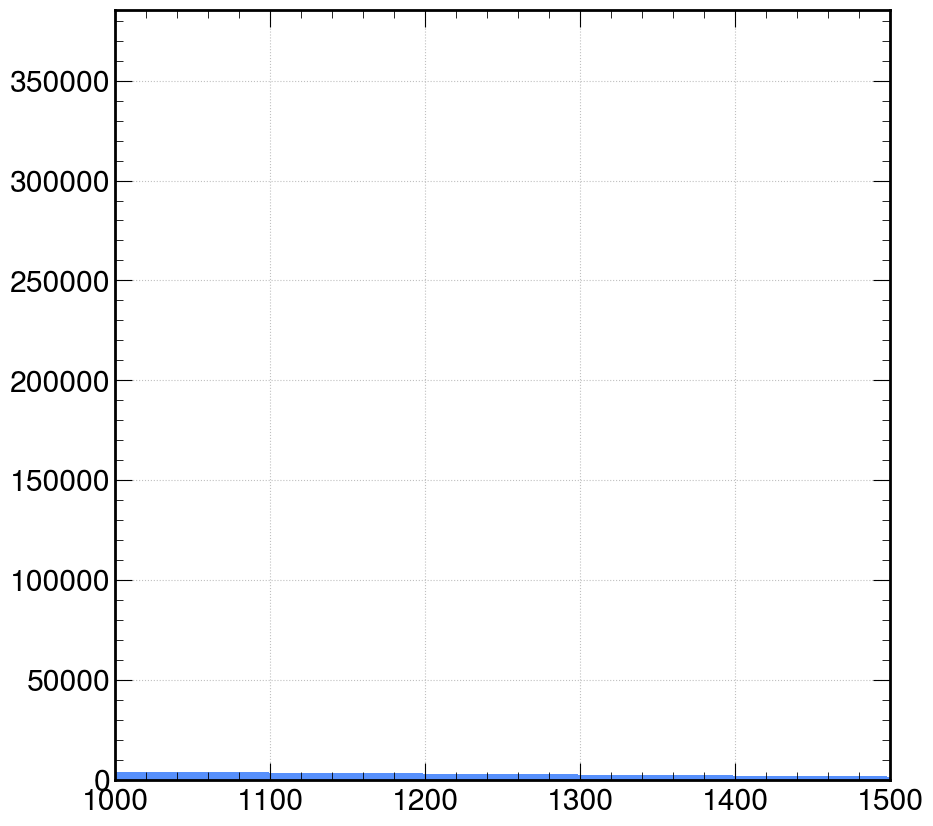

In [32]:
df_events.loc[df_events['PID'].isin([12, -12]), 'E'].hist(bins=50).set_xlim(1000, 1500)

array([[<Axes: title={'center': 'E'}>]], dtype=object)

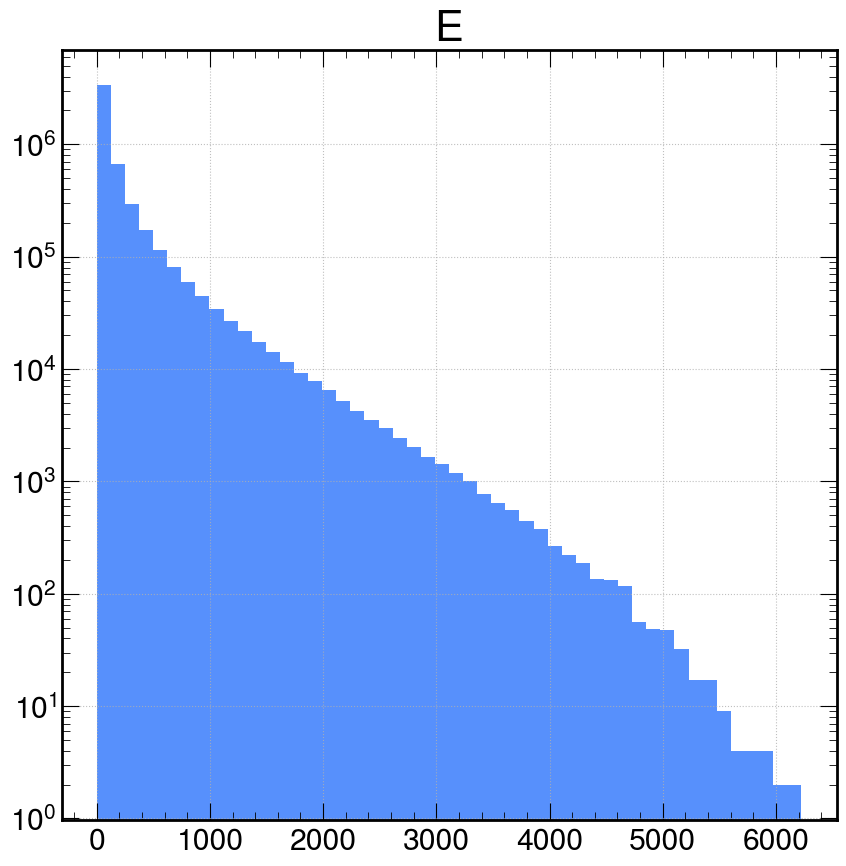

In [34]:
df_events.hist('E', bins=50, log=True)